# 필요 모듈 설치 및 임포트 & TPU 설정

In [1]:
!pip install transformers
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 7.5 MB/s eta 0:00:00


In [2]:
import os
import re
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from transformers import AutoTokenizer, AutoModel, TFAutoModel

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l1_l2


In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Colab GPU 사용
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
# Colab TPU 사용 
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.TPUStrategy(resolver)

KeyError: ignored

# 데이터 불러오고 확인

In [6]:
# 데이터 불러오기
data = pd.read_csv('/content/1120데이터.csv')
del data['Unnamed: 0']
# del data["Dalogue"]

# 라벨링 된 데이터만 불러오기
data = data.dropna()
data

,Emotion,Dalogue_stopwords
0,0,햇살 가득한 아침 눈 뜨니 기분 좋아
1,0,작은 꽃 송이 피어 나 마음 따뜻해졌어
2,0,오랜 만 친구 들 모 여서 웃으면서 행복한 보냈어
3,0,산책 하면서 새롭게 발견 공원 아름답고 기분 좋게 만들어줘
4,0,가족 함께 저녁 식사 하면서 나눈 이야기 소중한 이야
...,...,...
86525,3,기분 드럽네
86526,3,머리 나쁘네
86527,3,호구냐 참
86528,3,눈치 없어서 모르나 본데


In [ ]:
# 감정 라벨 컬럼 
data["Emotion"].unique()

array([0, 1, 3, 4, 5, 2])

In [7]:
# 감정 라벨별 데이터 수
data["Emotion"].value_counts()

2    30360
3    20568
4    16460
0    12661
5     5503
1      977
Name: Emotion, dtype: int64

# 함수 지정 및 모델 설정

In [101]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 128
NUM_EPOCHS = 7
VALID_SPLIT = 0.25
MAX_LEN = 50 # EDA에서 추출된 Max Length

In [14]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [64]:
# tokenizer = AutoTokenizer.from_pretrained("Definite/kobert-finetuned-klue-ner-finetuned-bible", cache_dir='bert_ckpt', do_lower_case=False)

In [65]:
test_sentence = "밥도 잘 먹질 못 해 네가 생각 날 까봐"

encode = tokenizer.encode(test_sentence)
token_print = [tokenizer.decode(token) for token in encode]

print(encode)
print(token_print)

[0, 1127, 2119, 1521, 1059, 2431, 1085, 1897, 752, 2116, 3628, 721, 653, 2998, 2]
['[CLS]', '밥', '##도', '잘', '먹', '##질', '못', '해', '네', '##가', '생각', '날', '까', '##봐', '[SEP]']


In [66]:
# Bert Tokenizer
def bert_tokenizer(sent, MAX_LEN):

    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.

    )

    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences

    return input_id, attention_mask, token_type_id

In [67]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(data["Dalogue_stopwords"], data["Emotion"]), total=len(data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_movie_input_ids = np.array(input_ids, dtype=int)
train_movie_attention_masks = np.array(attention_masks, dtype=int)
train_movie_type_ids = np.array(token_type_ids, dtype=int)
train_movie_inputs = (train_movie_input_ids, train_movie_attention_masks, train_movie_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len(train_movie_input_ids), len(train_data_labels)))

100%|██████████| 86529/86529 [00:09<00:00, 9195.24it/s] 


# sents: 86529, # labels: 86529


In [68]:
input_id = train_movie_input_ids[1]
attention_mask = train_movie_attention_masks[1]
token_type_id = train_movie_type_ids[1]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[    0  1518  2073   684 11938 19324   717  3717  5349 29919  2051     2
     2     2     2     2     2     2     2     2     2     2     2     2
     2     2     2     2     2     2     2     2     2     2     2     2
     2     2     2     2     2     2     2     2     2     2     2     2
     2     2]
[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[CLS] 작은 꽃 송이 피어 나 마음 따뜻해졌어 [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]


In [69]:
# with strategy.scope():
with tf.device('/device:GPU:0'):
    class TFBertClassifier(tf.keras.Model):
        def __init__(self, model_name, dir_path):
            super(TFBertClassifier, self).__init__()

            self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
            self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
            self.classifier = tf.keras.layers.Dense(6,
                                                    activation='softmax',
                                                    kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                                    name="classifier")
        def get_config(self):

            config = super().get_config().copy()
            config.update({
                'bert':self.bert,
                'dropout':self.dropout,
                'classifier':self.classifier,
            })
            return config

        def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):

            #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
            outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
            pooled_output = outputs[1]
            pooled_output = self.dropout(pooled_output, training=training)
            logits = self.classifier(pooled_output)

            return logits

In [27]:
sentiment_model = TFBertClassifier(model_name='bert-base-multilingual-cased', dir_path='bert_ckpt')

config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/452M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['electra.encoder.layer.5.attention.self.value.bias', 'electra.encoder.layer.11.output.dense.bias', 'electra.encoder.layer.2.attention.self.key.bias', 'electra.encoder.layer.2.attention.self.query.weight', 'electra.encoder.layer.0.attention.self.value.weight', 'electra.encoder.layer.10.intermediate.dense.weight', 'electra.encoder.layer.6.attention.output.dense.bias', 'electra.encoder.layer.5.attention.output.LayerNorm.bias', 'electra.encoder.layer.8.output.dense.weight', 'electra.encoder.layer.11.attention.output.dense.bias', 'electra.encoder.layer.2.output.LayerNorm.bias', 'electra.encoder.layer.6.attention.self.value.bias', 'electra.encoder.layer.4.attention.self.value.weight', 'electra.encoder.layer.6.output.LayerNorm.bias', 'electra.encoder.layer.4.intermediate.dense.weight', 'electra.encoder.layer.4.attention.self.value.bias', 'electra.encoder.layer.1.output.dense.bias', 'electra.encode

In [70]:
# sentiment_model = TFBertClassifier(model_name='Definite/kobert-finetuned-klue-ner-finetuned-bible',
#                                   dir_path='bert_ckpt')

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['electra.encoder.layer.5.attention.self.value.bias', 'electra.encoder.layer.11.output.dense.bias', 'electra.encoder.layer.2.attention.self.key.bias', 'electra.encoder.layer.2.attention.self.query.weight', 'electra.encoder.layer.0.attention.self.value.weight', 'electra.encoder.layer.10.intermediate.dense.weight', 'electra.encoder.layer.6.attention.output.dense.bias', 'electra.encoder.layer.5.attention.output.LayerNorm.bias', 'electra.encoder.layer.8.output.dense.weight', 'electra.encoder.layer.11.attention.output.dense.bias', 'electra.encoder.layer.2.output.LayerNorm.bias', 'electra.encoder.layer.6.attention.self.value.bias', 'electra.encoder.layer.4.attention.self.value.weight', 'electra.encoder.layer.6.output.LayerNorm.bias', 'electra.encod

In [102]:
MIN_DELTA = 1e-3
PATIENCE = 5

early_stopping = EarlyStopping(
    monitor = "accuracy",
    min_delta = MIN_DELTA,
    patience = PATIENCE)

# 최고 성능의 모델 파일을 저장할 이름과 경로 설정
BEST_MODEL_NAME = '/content/checkpoint/best_model_1122_ver2_15epoch.h5'
model_checkpoint = ModelCheckpoint(
    filepath = BEST_MODEL_NAME,
    save_weights_only=True,
    monitor = "accuracy",
    mode = "min",
    save_best_only = True, # 성능 향상 시에만 모델 저장
    verbose = 1
)

callbacks = [early_stopping, model_checkpoint]

In [29]:
total_steps = (86529 / BATCH_SIZE) * NUM_EPOCHS

In [30]:
total_steps =int(total_steps)

In [103]:
# Rectified Adam 옵티마이저 사용
opt = tfa.optimizers.RectifiedAdam(lr=1e-5, total_steps = 64, warmup_proportion=0.1, min_lr=1e-6, epsilon=1e-8, clipnorm=0.5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
sentiment_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

# **모델 학습**

In [104]:
# 학습과 eval 시작
history = sentiment_model.fit(train_movie_inputs, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT,callbacks = callbacks)

# 학습 이력 출력
print(history.history)

Epoch 1/7
507/507 [==============================] - ETA: 0s - loss: 0.8161 - accuracy: 0.6637
Epoch 1: accuracy improved from inf to 0.66369, saving model to /content/checkpoint/best_model_1122_ver2_15epoch.h5
507/507 [==============================] - 253s 455ms/step - loss: 0.8161 - accuracy: 0.6637 - val_loss: 6.0488 - val_accuracy: 0.0856
Epoch 2/7
507/507 [==============================] - ETA: 0s - loss: 0.8042 - accuracy: 0.6689
Epoch 2: accuracy did not improve from 0.66369
507/507 [==============================] - 225s 445ms/step - loss: 0.8042 - accuracy: 0.6689 - val_loss: 6.1290 - val_accuracy: 0.0905
Epoch 3/7
507/507 [==============================] - ETA: 0s - loss: 0.7882 - accuracy: 0.6777
Epoch 3: accuracy did not improve from 0.66369
507/507 [==============================] - 225s 445ms/step - loss: 0.7882 - accuracy: 0.6777 - val_loss: 6.4752 - val_accuracy: 0.0905
Epoch 4/7
507/507 [==============================] - ETA: 0s - loss: 0.7727 - accuracy: 0.6840
Epoch

# **그래프 확인**

In [105]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.show()

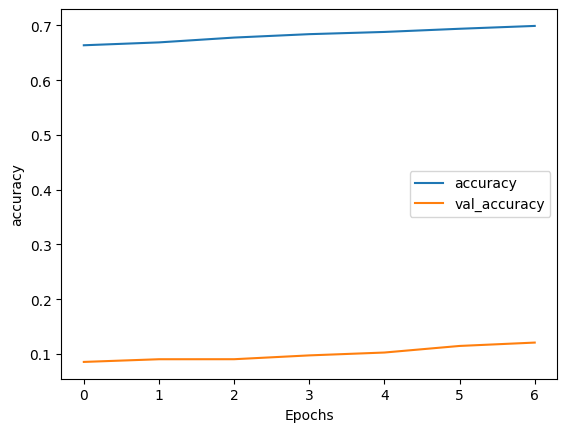

In [106]:
plot_graphs(history, 'accuracy')

In [45]:
def sentence_convert_data(data):
    global bert_tokenizer
    tokens , masks , segment = [],[],[]
    input_id , attention_mask , token_type_id = bert_tokenizer(data , MAX_LEN)

    tokens.append(input_id)
    masks.append(attention_mask)
    segment.append(token_type_id)

    tokens = np.array(tokens,dtype=int)
    masks = np.array(masks,dtype=int)
    segments = np.array(segment,dtype=int)

    return [tokens,masks,segments]

In [107]:
# 모델을 SavedModel 형식으로 저장
sentiment_model.save_weights("/content/best_model_1122_ver2_15epochs.h5")

# **모델 가중치 로드 후 예측함수 생성**

In [179]:
import tensorflow as tf
import pandas as pd
import numpy as np
from transformers import TFBertModel, BertTokenizer
from transformers import AutoTokenizer, AutoModel, TFAutoModel


# BERT 토크나이저와 모델 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

# KOBERT
# tokenizer = AutoTokenizer.from_pretrained("Definite/kobert-finetuned-klue-ner-finetuned-bible")
# bert_model = TFBertModel.from_pretrained('Definite/kobert-finetuned-klue-ner-finetuned-bible')

MAX_LEN = 50

def bert_tokenizer(sent, MAX_LEN):

    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.

    )

    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences

    return input_id, attention_mask, token_type_id


# 사용자 정의 모델 정의
class CustomBERTModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(CustomBERTModel, self).__init__()
        self.bert = bert_model
        # 추가적인 레이어는 필요에 따라 정의
        self.dropout = tf.keras.layers.Dropout(0.1)  # 예시로 dropout 레이어 추가
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        # BERT 모델의 출력을 가져옵니다.
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output, training=training)
        return self.classifier(pooled_output)

# 클래스 개수
model = CustomBERTModel(6)

# 모델에 적절한 입력 데이터 제공하여 내부 구조 초기화
test_input = tokenizer.encode_plus("테스트 문장", return_tensors='tf', padding='max_length', max_length=128, truncation=True)
model(test_input['input_ids'], attention_mask=test_input['attention_mask'], token_type_ids=test_input['token_type_ids'])

# 가중치 로드
model.load_weights('/Users/planebusuber/Downloads/1120_saved_model_10epoch.h5')

def sentence_convert_data(data):
    global bert_tokenizer
    tokens , masks , segment = [],[],[]
    input_id , attention_mask , token_type_id = bert_tokenizer(data , MAX_LEN)
    tokens.append(input_id)
    masks.append(attention_mask)
    segment.append(token_type_id)
    tokens = np.array(tokens,dtype=int)
    masks = np.array(masks,dtype=int)
    segments = np.array(segment,dtype=int)
    return [tokens,masks,segments]


def lyrics_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)  # 문장을 모델 입력 형식으로 변환
    predict = model.predict(data_x)
    predict_value = np.ravel(predict[0])
    # 예측된 클래스의 인덱스를 찾기.

    predicted_class = np.argmax(predict_value)
    if predicted_class == 0:
        print("(기쁨 확률: {:.2f}) 기쁨을 나타내는 문장입니다.".format(predict_value[predicted_class]))
    elif predicted_class == 1:
        print("(사랑 확률: {:.2f}) 사랑을 나타내는 문장입니다.".format(predict_value[predicted_class]))
    elif predicted_class == 2:
        print("(슬픔 확률: {:.2f}) 슬픔을 나타내는 문장입니다.".format(predict_value[predicted_class]))
    elif predicted_class == 3:
        print("(분노 확률: {:.2f} 분노를 나타내는 문장입니다.)".format(predict_value[predicted_class]))
    elif predicted_class == 4:
        print("(걱정 확률: {:.2f} 걱정을 나타내는 문장입니다.)".format(predict_value[predicted_class]))
    elif predicted_class == 5:
        print("(중립 확률: {:.2f} 중립을 나타내는 문장입니다.)".format(predict_value[predicted_class]))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

# 텍스트로 예측

In [182]:
lyrics_evaluation_predict('''
Oh 너가 없는 날 oh
바보같이 난 오늘도
널 떠올리는 중이야 oh yeah
아픈 너의 맘을 oh oh
안아줄 수는 없어도
난 지금 생각 중이야 oh oh
너에게 난 부족한 사람
늘 모자란 사람
나의 예감은
나에게 넌 어려운 사람
참 아까운 사람
상처 많은 참 못났던 사람
널 울리고서
다신 안 볼 것처럼
널 밀어내고
그땐 뭐가 그리 힘들었는지
떠나버린 사랑에
아쉬운 밤을 보네
네가 떠난 날
다신 없을 걸 아는데
널 기다리는 중이야 oh oh
사랑했던 날
함께한 시간들이 날
괴롭히는 중이야 oh oh
너에게 난 부족한 사람
늘 모자란 사람
네 맘도 모르던 사람
나에게 넌 어려운 사람
참 아쉬운 사람
상처만 주고 떠나요
참 못났던 사람
널 울리고서 다신 안 볼 것처럼
널 밀어내고
그땐 뭐가 그리 힘들었는지
떠나버린 사랑에
아쉬운 밤을 보네
참 못났던 사람
널 울리고서
다신 안 볼 것처럼
널 밀어내고
그땐 뭐가 그리 힘들었는지
떠나버린 사랑에
아쉬운 밤을 보네
''')

1/1 [==============================] - 1s 602ms/step
(슬픔 확률: 0.26) 슬픔을 나타내는 문장입니다.


In [198]:
lyrics_evaluation_predict('''
心から愛してる
''')#사랑합니다

1/1 [==============================] - 0s 397ms/step
(사랑 확률: 1.00) 사랑을 나타내는 문장입니다.


In [199]:
lyrics_evaluation_predict('''
馬鹿野郎
''')#빠가야로

1/1 [==============================] - 1s 648ms/step
(분노 확률: 0.48 분노를 나타내는 문장입니다.)


In [200]:
lyrics_evaluation_predict('''
悲しいですね
''')#슬프네요

1/1 [==============================] - 1s 628ms/step
(슬픔 확률: 0.94) 슬픔을 나타내는 문장입니다.


In [201]:
lyrics_evaluation_predict('''
i love you
''')

1/1 [==============================] - 0s 386ms/step
(사랑 확률: 0.99) 사랑을 나타내는 문장입니다.


In [195]:
lyrics_evaluation_predict('''
健康的な朝だな
こんな時に君の"愛してる"が聞きたいや
揺れるカーテン
少し浮いた前髪も
すべて心地いいさ
それに割れてしまった目玉焼き
ついてないなあ
バランスをとっても溢れちゃうや
少し辛くて 少し酸っぱくて
甘ったるかったりさ
とりあえず今日は
バラの花に願い込めてさ
馬鹿な夢で踊ろう
愛を伝えたいだとか
臭いことばっか考えて待ってても
だんだんソファに沈んでいくだけ
僕が明日良い男になるわけでもないからさ
焦らずにいるよ
今日は日が落ちる頃に会えるの？
"完璧な男になんて惹かれない"と
君が笑ってたから悔しいや
腐るほどに話したいこと沢山あるのにな
寂しいさ
結局のところ君はさ
どうしたいの？
まじで僕に愛される気あんの？
雫が落ちてる
窓際目の際お気に入りの花
とりあえず今日は
部屋の明かり早めに消してさ
どうでもいい夢を見よう
明日は2人で過ごしたいなんて
考えていてもドアは開かないし
だんだんおセンチになるだけだ僕は
愛が何だとか言うわけでもないけど
ただ切ないと言えばキリがないくらいなんだ
もう嫌だ
ろうそく炊いて
バカでかいケーキがあっても
君が食いつくわけでもないだろう
情けないずるい事ばかりを
考えてしまう今日は
バラの花もないよ
汚れてるシャツに履き慣れたジーパンで
愛を伝えたいだとか
臭いことばっか考えて待ってても
だんだんソファに沈んでいくだけ
僕が明日良い男になるわけでもないからさ
焦らずにいるよ
今日は日が落ちる頃に会えるの？
''')

1/1 [==============================] - 0s 370ms/step
(사랑 확률: 0.47) 사랑을 나타내는 문장입니다.


In [190]:
lyrics_evaluation_predict('''
Weight of the world on your shoulders
I'll kiss your waist and ease your mind
I must be favored to know ya
I'll take my hands and trace your lines
It's the way that you can ride
It's the way that you can ride (oh-oh, oh-oh)
Think I met you in another life
So break me off another time (oh-oh, oh-oh)
You wrap around me and you give me life
And that's why night after night
I'll be fuckin' you right
Monday, Tuesday, Wednesday, Thursday, Friday
Saturday, Sunday (a week)
Monday, Tuesday, Wednesday, Thursday, Friday
Seven days a week
Every hour, every minute, every second
You know night after night
I'll be fuckin' you right, seven days a week (yeah)
I'll be fuckin' you right, seven days a week
I'll be fuckin' you right, seven days a week
You love when I jump right in
All of me, I'm offering
Show you what devotion is
Deeper than the ocean is
Wind it back, I'll take it slow
Leave you with that afterglow
Show you what devotion is
Deeper than the ocean is
It's the way that you can ride
It's the way that you can ride (oh-oh, oh-oh)
Think I met you in another life
So break me off another time (oh-oh, oh-oh)
You wrap around me and you give me life
And that's why night after night
I'll be fuckin' you right, oh-oh-oh-oh
Monday, Tuesday, Wednesday, Thursday, Friday
Saturday, Sunday (a week)
Monday, Tuesday, Wednesday, Thursday, Friday
Seven days a week
Every hour, every minute, every second
You know night after night
I'll be fuckin' you right, seven days a week (yeah)
I'll be fuckin' you right, seven days a week
I'll be fuckin' you right, seven days a week
Tightly take control, tightly take his soul
Take your phone and put it in the camera roll
Leave them clothes at the door
Watchu waitin' for? Better come and hit yo' goals
Uh, he jump in it, both feet
Goin' 'til the sun up, we ain't gettin' no sleep
Seven days a week, seven different sheets
Seven different angles, I could be your fantasy
Monday, Tuesday, Wednesday, Thursday, Friday
Saturday, Sunday (a week)
Monday, Tuesday, Wednesday, Thursday, Friday
Seven days a week
Every hour, every minute, every second
You know night after night
I'll be fuckin' you right, seven days a week (yeah)
''')

1/1 [==============================] - 0s 466ms/step
(사랑 확률: 0.75) 사랑을 나타내는 문장입니다.


In [191]:
lyrics_evaluation_predict('''
例えば僕ら二人 煌めく映画のように
出会いなおせたらどうしたい
何も謎めいてない 今日は昨日の続き
日々は続くただぼんやり
微かな足音 シーツの置く場所
それだけで全てわかってしまうよ
見え透いた嘘も隠した本当も
その全て愛おしかった
レディー 笑わないで聞いて
ハニー 見つめ合っていたくて
君と二人 行ったり来たりしたいだけ
ベイビー 子供みたいに恋がしたい
書き散らしていく僕らのストーリーライン
例えばどっちか一人 ひどい不幸が襲い
二度と会えなくなったら
考えた矢先に 泣けてしまうくらい
日々は続く一層確かに
いつもの暗い顔 チープな戯言
見過ごすようにまた優しいんだろう
見え透いた嘘も隠した本当も
その目から伝わってきた
引っ張ったり噛み付いたり 傷ついたふりしてみたり
明日の朝に持ち越したり 浮ついたりして
思いきり傷つきたい いつまでもそばにいたい
今すぐ行方をくらまそう
レディー 何も言わないで
ハニー 僕の手を取ってくれ
君以外に 考えられないだけ
ベイビー あの頃みたいに恋がしたい
書き散らしていく 踊り続ける
レディー 笑わないで聞いて
ハニー 見つめ合っていたくて
君と二人 行ったり来たりしたいだけ
ベイビー 子供みたいに恋がしたい
書き散らしていく僕らのストーリーライン
''')

1/1 [==============================] - 0s 471ms/step
(슬픔 확률: 0.70) 슬픔을 나타내는 문장입니다.


In [192]:
lyrics_evaluation_predict('''
少し寂しそうな君に
こんな歌を聴かせよう
手を叩く合図 雑なサプライズ
僕なりの精一杯
埃まみれ ドーナツ盤には
あの日の夢が踊る
真面目に針を落とす
息を止めすぎたぜ
さあ腰を落ろしてよ
フツフツと鳴り出す青春の音
乾いたメロディーで踊ろうよ
君はロックなんか聴かないと 思いながら
少しでも僕に近づいてほしくて
ロックなんか聴かないと 思うけれども
僕はこんな歌で あんな歌で 恋を乗り越えてきた
僕の心臓のBPMは
190になったぞ
君は気づくのかい？
なぜ今笑うんだい？
嘘みたいに泳ぐ目
ダラダラと流れる青春の音
乾いたメロディーは止まないぜ
君はロックなんか聴かないと 思いながら
あと少し僕に近づいてほしくて
ロックなんか聴かないと 思うけれども
僕はこんな歌で あんな歌で 恋に焦がれてきたんだ
君がロックなんか聴かないこと 知ってるけど
恋人のように寄り添ってほしくて
ロックなんか聴かないと 思うけれども
僕はこんな歌であんな歌で また胸が痛いんだ
君はロックなんか聴かないと 思いながら
少しでも僕に近づいてほしくて
ロックなんか聴かないと 思うけれども
僕はこんな歌で あんな歌で 恋を乗り越えてきた
恋を乗り越えてきた
''')

1/1 [==============================] - 0s 448ms/step
(사랑 확률: 0.99) 사랑을 나타내는 문장입니다.


## 추가학습

### 추가 학습할 데이터 불러오기

In [ ]:
more_data = pd.read_csv("/content/1117사랑분노데이터.csv")

In [ ]:
# more_data = more_data.drop("Unnamed: 0", axis=1)
more_data = more_data.dropna()

### 추가학습 코드

In [ ]:
# 가중치 로드
model.load_weights('/content/1117_saved_model_10epoch.h5')


def prepare_data(data):
    input_ids, attention_masks, token_type_ids, labels = [], [], [], []

    for _, row in data.iterrows():
        sentence = row['Dalogue_stopwords']
        label = row['Emotion']
        input_id, attention_mask, token_type_id = bert_tokenizer(sentence, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        labels.append(label)

    return np.array(input_ids), np.array(attention_masks), np.array(token_type_ids), np.array(labels)

input_ids, attention_masks, token_type_ids, labels = prepare_data(more_data)

opt = tfa.optimizers.RectifiedAdam(lr=1e-5, total_steps = 64, warmup_proportion=0.1, min_lr=1e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

history = model.fit(
    [input_ids, attention_masks, token_type_ids],
    labels,
    validation_split=0.3,
    batch_size=128,
    epochs=5
)

Epoch 1/5
1/1 [==============================] - 41s 41s/step - loss: 2.8762 - accuracy: 0.3306 - val_loss: 0.3050 - val_accuracy: 0.8868
Epoch 2/5
1/1 [==============================] - 6s 6s/step - loss: 2.9640 - accuracy: 0.3388 - val_loss: 0.3051 - val_accuracy: 0.8868
Epoch 3/5
1/1 [==============================] - 6s 6s/step - loss: 2.9747 - accuracy: 0.3223 - val_loss: 0.3052 - val_accuracy: 0.8868
Epoch 4/5
1/1 [==============================] - 6s 6s/step - loss: 2.9238 - accuracy: 0.2975 - val_loss: 0.3055 - val_accuracy: 0.8868
Epoch 5/5
1/1 [==============================] - 6s 6s/step - loss: 2.7930 - accuracy: 0.3471 - val_loss: 0.3057 - val_accuracy: 0.8868


In [ ]:
# 추가학습 예측성능 확인하기
def predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = model.predict(data_x)
    predict_value = np.ravel(predict[0])
    predicted_class = np.argmax(predict_value)
    return predicted_class, predict_value[predicted_class]

sentence =  "짝남이랑 데이트"
predicted_class, confidence = predict(sentence)
print(f"감정: {predicted_class}, 확률: {confidence}")

1/1 [==============================] - 0s 114ms/step
감정: 2, 확률: 0.5108464360237122
